**Digit Recognizer Using Artificial Neural Network**

Source: https://www.kaggle.com/competitions/digit-recognizer/data

# Library

In [161]:
#Basic statistic & visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools

#Model
import tensorflow as tf
from tensorflow.keras import regularizers

#Confusion Matrix
from sklearn.metrics import confusion_matrix

#Hyperparameter Tuning
import keras_tuner as kt
from tensorflow import keras

#Image Converter
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# Load Dataset

## Train Dataset

In [2]:
df_train= pd.read_csv('train.csv')
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Test Dataset

In [3]:
df_test = pd.read_csv('test.csv')
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Dataset Information

In [4]:
#Shape
print('Train:',df_train.shape, 'Test:', df_test.shape)

Train: (42000, 785) Test: (28000, 784)


Data Train: Each row has 1 label and pixels with height 28 pixels and width 28 pixels.<br>
Data Test: Each row pixels with height 28 pixels and width 28 pixels.

## Determine Target

In [5]:
#x_train
data_train = (df_train.drop(columns=['label']))
data_train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#y_train
label = df_train['label']
label.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

# Exploratory Dataset Analysis (EDA)

## Sample Picture

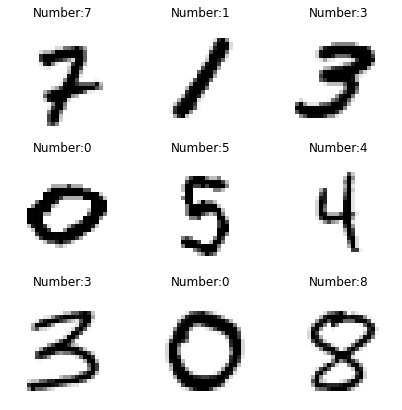

In [210]:
plt.figure(figsize=(7,7))
for i in range(9):
    ax = plt.subplot(3,3,i+1).axis(False)
    index = random.choice(range(len(df_train)))
    plt.imshow(data_train.iloc[index].to_numpy(dtype='float32').reshape((28, 28, 1)) / 255.0,cmap = plt.cm.binary)
    plt.title(f'Number:{label[index]}')

## Range of Data

In [8]:
print(f'''Maximum value: {data_train.iloc[0].max()}
Minimum value: {data_train.iloc[0].min()}''')

Maximum value: 255
Minimum value: 0


# Preprocessing

## Normalization

In [9]:
data_train_norm = data_train/255.0
df_test_norm = df_test/255.0

print(f'''x_train_norm:
Maximum value: {data_train_norm.iloc[0].max()}
Minimum value: {data_train_norm.iloc[0].min()}

df_test_norm
Maximum value: {df_test_norm.iloc[0].max()}
Minimum value: {df_test_norm.iloc[0].min()}''')

x_train_norm:
Maximum value: 1.0
Minimum value: 0.0

df_test_norm
Maximum value: 1.0
Minimum value: 0.0


## Shuffle Dataset

In [10]:
tf.random.set_seed(42)
data_train_s = tf.random.shuffle(data_train_norm,seed = 46)
label_s = tf.random.shuffle(label,seed = 46)

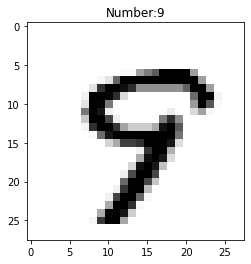

In [11]:
plt.imshow(tf.reshape(data_train_s[-3],[28,28]) / 255.0,cmap = plt.cm.binary)
plt.title(f'Number:{label_s[-3]}')
plt.show()

## Splitting

In [12]:
x_train = data_train_s[:round((len(data_train_s)*0.7))]
y_train = label_s[:round((len(label_s)*0.7))]
x_test = data_train_s[round((len(data_train_s)*0.7)):]
y_test = label_s[round((len(label_s)*0.7)):]

In [13]:
print(f'''x_train: {x_train.shape[0]}
y_train: {y_train.shape[0]}
x_test: {x_test.shape[0]}
y_test: {y_test.shape[0]}''')

x_train: 29400
y_train: 29400
x_test: 12600
y_test: 12600


# Modeling

## Visualization Function

In [14]:
#Plot Model Accuracy
def loss(x):
    plt.plot(x.history['accuracy'])
    plt.plot(x.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=0)
    plt.show()

In [15]:
#Plot Learning Rate
def loss_lr(x):
    plt.plot(x.history['loss'])
    plt.plot(x.history['val_loss'])
    plt.plot(x.history['lr'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'test'], loc=0)
    plt.show()

In [16]:
#Plot the learning Rate vs Loss
def lr_plot(x):
    lrs = 1e-4 * 10**(tf.range(len(x.history['loss']))/20)
    plt.figure(figsize=(10,7))
    plt.semilogx(lrs,x.history['loss'])
    plt.xlabel("Learning Rate")
    plt.ylabel("Loss")
    plt.title("Learning Rate VS Loss")

In [17]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15): 

    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    n_classes = cm.shape[0]

    # Plot the figure
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) #darker == better
    fig.colorbar(cax)

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes), 
         xticklabels=labels,
         yticklabels=labels)
  
    #x-axis labels
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

## Basic Model

In [66]:
#Set Random Seed
tf.random.set_seed(42)

#Create Model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(10,
                          activation='softmax',
                          name="output_layer")
],name = 'basic_model')

#Compiling Model
model_1.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#Fitting Model
history1 = model_1.fit(x_train,y_train,
                       epochs=10, 
                       validation_split=0.3,
                       verbose=0)

### Evaluation Data Train

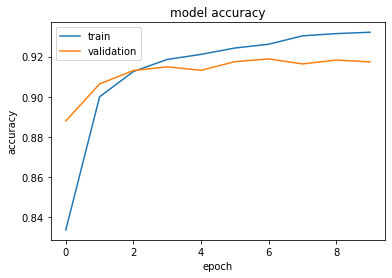

919/919 [==============================] - 1s 1ms/step - loss: 0.2501 - accuracy: 0.9305


[0.25010091066360474, 0.9305441975593567]

In [224]:
loss(history1)
sc_model1 = model_1.evaluate(x_train,y_train)
sc_model1

### Evaluation Data Test

In [225]:
sc_model1_t = model_1.evaluate(x_test,y_test)
sc_model1_t

394/394 [==============================] - 0s 1ms/step - loss: 0.2863 - accuracy: 0.9179


[0.2862538695335388, 0.9178571701049805]

### Weight

In [239]:
#5 first weight
model_1.layers[0].get_weights()[0][:5]

array([[ 0.02861048, -0.01025646, -0.02557759, -0.006175  , -0.08107699,
         0.03210682,  0.0417464 ,  0.06475256, -0.04758043, -0.04812451],
       [-0.0329656 ,  0.03865492, -0.06377345,  0.0083563 ,  0.01297136,
         0.06948828, -0.0852838 ,  0.00369113,  0.02339167, -0.05227426],
       [ 0.03988699,  0.00796872, -0.06822798,  0.03072181,  0.02786536,
        -0.02834752,  0.0176323 , -0.05031011,  0.06132627, -0.01032341],
       [ 0.07798023, -0.04563329,  0.05420778,  0.00457933, -0.0009896 ,
        -0.04935341,  0.06010623,  0.06465513, -0.03331364,  0.03247739],
       [-0.04561339,  0.04897984,  0.08121588, -0.07498479,  0.05193832,
         0.02786724,  0.01515197, -0.05830912,  0.04139606, -0.03120053]],
      dtype=float32)

### Bias

In [240]:
model_1.layers[0].get_weights()[1]

array([-0.2549661 ,  0.44389713,  0.05706877, -0.23941413,  0.08370189,
        0.61794555, -0.0064534 ,  0.36305588, -0.83284235, -0.14790612],
      dtype=float32)

## Determine Batch

### Batch Size = 64

In [74]:
#Set Random Seed
tf.random.set_seed(42)

#Create Model
model_1b = tf.keras.Sequential([
    tf.keras.layers.Dense(10,
                          activation='softmax',
                          name="output_layer")
],name = 'batch_size_64')

#Compiling Model
model_1b.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

#Fitting Model
history1b = model_1b.fit(x_train,y_train,
                         epochs=10, 
                         batch_size=64 ,
                         validation_split=0.3,
                         verbose=0)

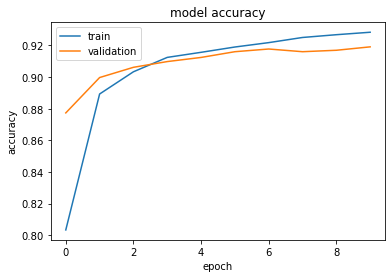

919/919 [==============================] - 1s 1ms/step - loss: 0.2627 - accuracy: 0.9276


[0.26268118619918823, 0.9275850057601929]

In [75]:
loss(history1b)
model_1b.evaluate(x_train,y_train)

### Batch Size = 96

In [22]:
#Set Random Seed
tf.random.set_seed(42)

#Create Model
model_1c = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='softmax',name="output_layer")
],name = 'batch_size_96')

#Compiling Model
model_1c.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

#Fitting Model
history1c = model_1c.fit(x_train,y_train,
                         epochs=10, 
                         batch_size=96 ,
                         validation_split=0.3,
                         verbose=0)

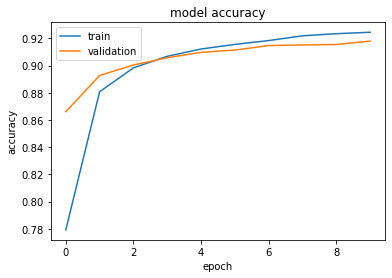

919/919 [==============================] - 1s 1ms/step - loss: 0.2738 - accuracy: 0.9244


[0.27376988530158997, 0.9243537187576294]

In [23]:
loss(history1c)
model_1c.evaluate(x_train,y_train)

## Increase Epochs

In [24]:
#Set Random Seed
tf.random.set_seed(42)

#Create Model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(10, 
                          activation='softmax',
                          name="output_layer")
],name = 'increase_epochs')

#Compiling Model
model_2.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
#Callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

#Fitting Model
history2 = model_2.fit(x_train,y_train,
                       epochs=100, 
                       callbacks=[callback], 
                       batch_size = 96, 
                       validation_split=0.3,
                       verbose=0)

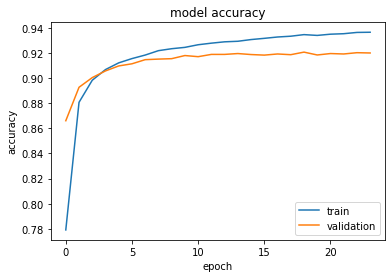

919/919 [==============================] - 1s 1ms/step - loss: 0.2431 - accuracy: 0.9330


[0.24308085441589355, 0.9330272078514099]

In [25]:
loss(history2)
model_2.evaluate(x_train,y_train)

## Add Hidden Layer

In [76]:
#Set Random Seed
tf.random.set_seed(42)

#Create Model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(4,activation='relu',name='hidden1'),
    tf.keras.layers.Dense(4,activation='relu',name='hidden2'),
    tf.keras.layers.Dense(10, activation='softmax',name="output_layer")
],name = 'hidden_layer')

#Compiling Model
model_3.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
#Callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

#Fitting Model
history3 = model_3.fit(x_train,y_train,
                       epochs=100, 
                       callbacks=[callback], 
                       batch_size = 96, 
                       validation_split=0.3,
                       verbose=0)

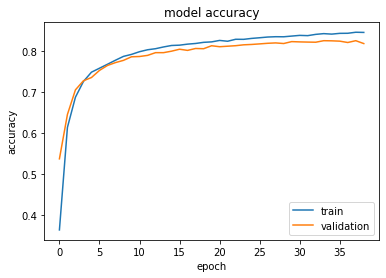

919/919 [==============================] - 2s 2ms/step - loss: 0.5456 - accuracy: 0.8357


[0.545629620552063, 0.8357142806053162]

In [77]:
loss(history3)
model_3.evaluate(x_train,y_train)

## Determine Regularizer

In [78]:
#Set Random Seed
tf.random.set_seed(42)

#Create Model
model_3a = tf.keras.Sequential([
    tf.keras.layers.Dense(4,
                          kernel_regularizer=regularizers.l2(0.001),
                          activation='relu',
                          name='hidden1'),
    tf.keras.layers.Dense(4,
                          kernel_regularizer=regularizers.l2(0.001),
                          activation='relu',
                          name='hidden2'),
    tf.keras.layers.Dense(10,
                          activation='softmax',
                          name="output_layer")
],name = 'regulizer')

#Compiling Model
model_3a.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
#Callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

#Fitting Model
history3a = model_3a.fit(x_train,y_train,
                       epochs=100, 
                       callbacks=[callback], 
                       batch_size = 96, 
                       validation_split=0.3,
                       verbose=0)

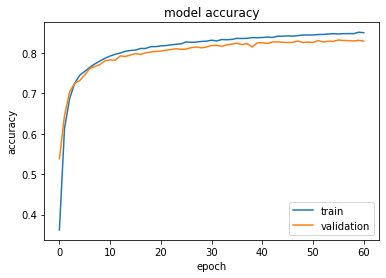

919/919 [==============================] - 1s 1ms/step - loss: 0.5696 - accuracy: 0.8444


[0.5695598721504211, 0.8443537354469299]

In [79]:
loss(history3a)
model_3a.evaluate(x_train,y_train)

## Change Optimizer

In [80]:
#Set Random Seed
tf.random.set_seed(42)

#Create Model
model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(4,
                          kernel_regularizer=regularizers.l2(0.001),
                          activation='relu',
                          name='hidden1'),
    tf.keras.layers.Dense(4,
                          kernel_regularizer=regularizers.l2(0.001),
                          activation='relu',
                          name='hidden2'),
    tf.keras.layers.Dense(10, 
                          activation='softmax',
                          name="output_layer")
],name = 'change_optimizer')

#Compiling Model
model_4.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
#Callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

#Fitting Model
history4 = model_4.fit(x_train,y_train,
                       epochs=100, 
                       callbacks=[callback], 
                       batch_size=96, 
                       validation_split=0.3,
                       verbose=0)

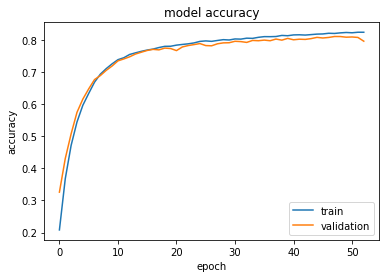

919/919 [==============================] - 1s 1ms/step - loss: 0.6558 - accuracy: 0.8045


[0.6557914614677429, 0.80448979139328]

In [81]:
loss(history4)
model_4.evaluate(x_train,y_train)

## Adjust Learning Rate

### Determine Learning Rate

In [82]:
#Set Random Seed
tf.random.set_seed(42)

#Create Model
model_5 = tf.keras.Sequential([
    tf.keras.layers.Dense(4,
                          kernel_regularizer=regularizers.l2(0.001),
                          activation='relu',
                          name='hidden1'),
    tf.keras.layers.Dense(4,
                          kernel_regularizer=regularizers.l2(0.001),
                          activation='relu',
                          name='hidden2'),
    tf.keras.layers.Dense(10,
                          activation='softmax',
                          name="output_layer")
],name = 'learning_rate')

#Compiling Model
model_5.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# #Callbacks
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

#Fitting Model
history5 = model_5.fit(x_train,y_train,
                       epochs=100, 
                       callbacks=[lr_scheduler], 
                       batch_size = 96,
                       validation_split=0.3,
                       verbose=0)

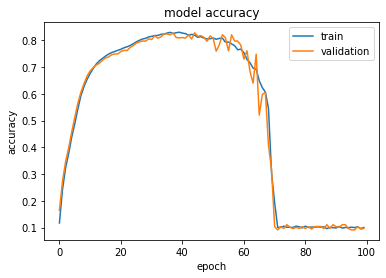

In [83]:
loss(history5)

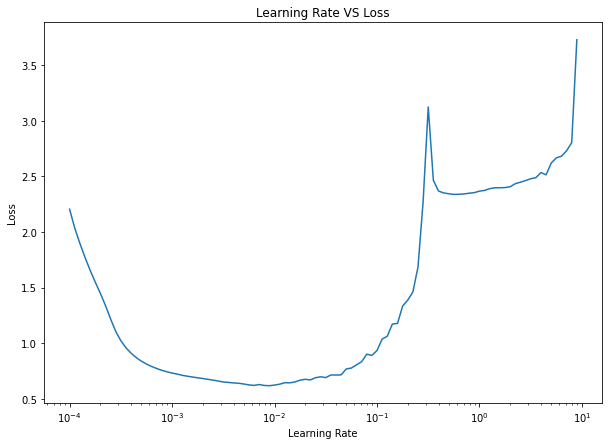

In [84]:
lr_plot(history5)

### Set LR = 0.002

In [88]:
#Set Random Seed
tf.random.set_seed(42)

#Create Model
model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(4,
                          kernel_regularizer=regularizers.l2(0.001),
                          activation='relu',
                          name='hidden1'),
    tf.keras.layers.Dense(4,
                          kernel_regularizer=regularizers.l2(0.001),
                          activation='relu',
                          name='hidden2'),
    tf.keras.layers.Dense(10,
                          activation='softmax',
                          name="output_layer")
],name = 'lr_0002')

#Compiling Model
model_6.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate = 0.002),
                metrics=["accuracy"])
#Callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

#Fitting Model
history6 = model_6.fit(x_train,y_train,
                       epochs=100, 
                       callbacks=[callback],
                       batch_size=96, 
                       validation_split=0.3,
                       verbose=0)

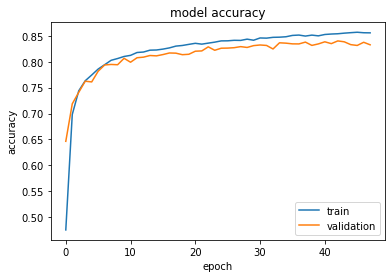

919/919 [==============================] - 1s 1ms/step - loss: 0.5525 - accuracy: 0.8495


[0.5525022149085999, 0.8495237827301025]

In [89]:
loss(history6)
model_6.evaluate(x_train,y_train)

## Model Artificial Neural Network

Selected Model: model_6

### Evaluation Data Train

In [222]:
sc_model6= model_6.evaluate(x_train,y_train)
sc_model6

919/919 [==============================] - 1s 1ms/step - loss: 0.5525 - accuracy: 0.8495


[0.5525022149085999, 0.8495237827301025]

### Evaluation Data Test

In [223]:
sc_model6_t= model_6.evaluate(x_test,y_test)
sc_model6_t

394/394 [==============================] - 1s 1ms/step - loss: 0.6027 - accuracy: 0.8321


[0.6026783585548401, 0.8321428298950195]

### Prediction Data Test

In [92]:
#Probability
y_probs_nn = model_6.predict(x_test)
y_probs_nn[:5]

array([[2.7161695e-05, 7.3224213e-12, 2.7028698e-05, 1.3276123e-11,
        5.0012721e-07, 2.4122737e-06, 9.9994230e-01, 1.0385236e-21,
        5.8310258e-07, 6.1591891e-11],
       [7.6261284e-05, 4.6312731e-08, 6.4295741e-06, 1.1850408e-05,
        9.7195733e-01, 1.4949579e-03, 2.9147638e-04, 2.9453138e-04,
        1.2679220e-05, 2.5854470e-02],
       [1.0787082e-02, 9.6514076e-01, 6.2265750e-03, 7.2488689e-04,
        2.3216708e-06, 2.2247435e-04, 3.6818619e-05, 7.9080935e-05,
        1.5924700e-02, 8.5515244e-04],
       [3.8829842e-07, 1.0084974e-05, 9.6908826e-01, 2.2667218e-02,
        5.1027433e-07, 2.1305783e-03, 5.3274925e-03, 2.0106102e-14,
        7.7537738e-04, 4.4716852e-08],
       [1.2344127e-06, 5.5642740e-05, 9.7100621e-01, 2.0666759e-02,
        1.9255906e-06, 1.7936868e-03, 5.6159436e-03, 1.4860647e-12,
        8.5837604e-04, 2.8693114e-07]], dtype=float32)

In [93]:
#Prediction
y_preds_nn = y_probs_nn.argmax(axis=1)
y_preds_nn[:10]

array([6, 4, 1, 2, 2, 9, 7, 0, 3, 5], dtype=int64)

### Evaluation Matrix

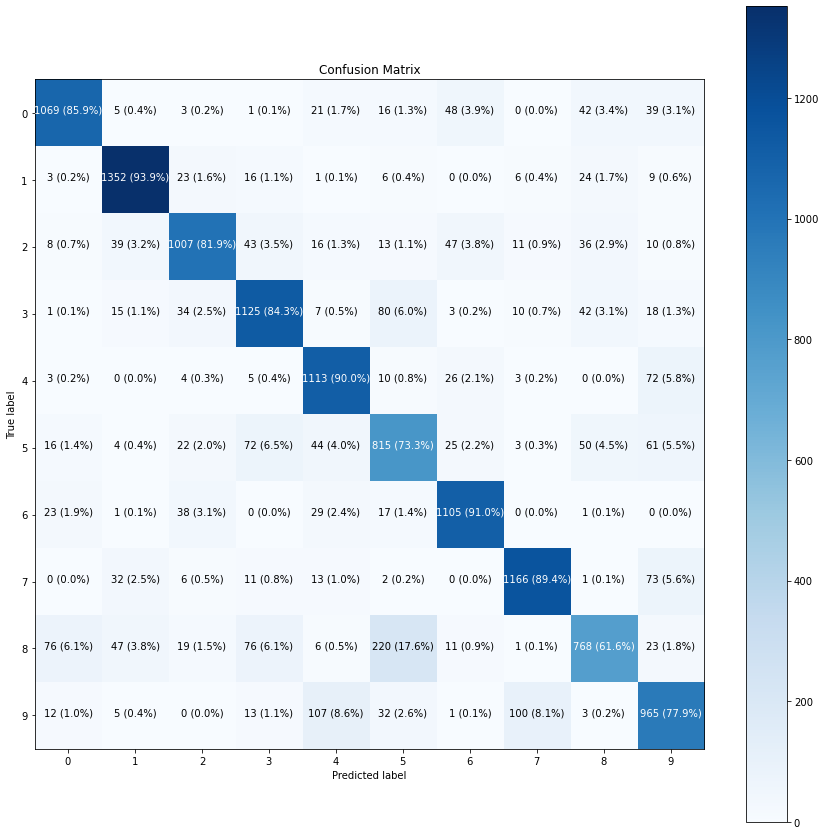

In [94]:
class_name = [0,1,2,3,4,5,6,7,8,9]

make_confusion_matrix(y_true=y_test, 
                      y_pred=y_preds_nn,
                      classes=class_name,
                      figsize=(15, 15),
                      text_size=10)

## Model Summary

In [218]:
model_6.summary()

Model: "lr_0002"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 4)                 3140      
                                                                 
 hidden2 (Dense)             (None, 4)                 20        
                                                                 
 output_layer (Dense)        (None, 10)                50        
                                                                 
Total params: 3,210
Trainable params: 3,210
Non-trainable params: 0
_________________________________________________________________


# Hyperparameter Tuning

## Create Model

In [110]:
def model_builder(hp):
    tf.random.set_seed(42)
    model = keras.Sequential(name='model_tuning')

    # Tune the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=4, max_value=8, step=1)
    
    model.add(keras.layers.Dense(units=hp_units,
                                 kernel_regularizer=regularizers.l2(0.001),
                                 activation='relu',
                                 name="hidden_1"))
    model.add(keras.layers.Dense(units=hp_units,
                                 kernel_regularizer=regularizers.l2(0.001),
                                 activation='relu', 
                                 name = 'hidden_2'))
    model.add(keras.layers.Dense(10,
                                 name="output_layer",
                                 activation='softmax'))
    
    #Compile Model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.002),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

In [111]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=100,
                     factor=5,
                     seed = 46,
                     project_name="Classification Tuner")

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [112]:
tuner.search(x_train,y_train, 
             epochs=100, 
             validation_split=0.3,
             batch_size=96,
             callbacks=[stop_early])

Trial 5 Complete [00h 00m 03s]
val_accuracy: 0.8878684639930725

Best val_accuracy So Far: 0.9028344750404358
Total elapsed time: 00h 00m 17s
INFO:tensorflow:Oracle triggered exit


## Evaluation

In [113]:
tuner.results_summary()

Results summary
Results in .\Classification Tuner
Showing 10 best trials
Trial summary
Hyperparameters:
units: 8
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.9028344750404358
Trial summary
Hyperparameters:
units: 7
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.8878684639930725
Trial summary
Hyperparameters:
units: 5
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.8611111044883728
Trial summary
Hyperparameters:
units: 6
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.8162131309509277
Trial summary
Hyperparameters:
units: 4
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.7623582482337952


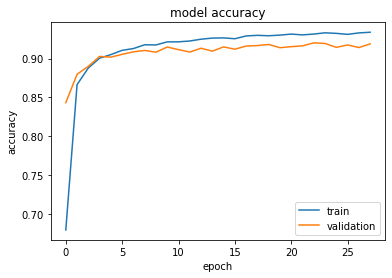

In [114]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

history_nn_tun = model.fit(x_train,y_train,
                           epochs=100,
                           validation_split=0.3,
                           batch_size=96,
                           callbacks=[stop_early],
                           verbose = 0)
loss(history_nn_tun)

### Evaluation Data Train

In [227]:
sc_model = model.evaluate(x_train,y_train)
sc_model

919/919 [==============================] - 1s 1ms/step - loss: 0.2904 - accuracy: 0.9336


[0.29041844606399536, 0.933605432510376]

### Evaluation Data Test

In [226]:
sc_model_t = model.evaluate(x_test,y_test)
sc_model_t

394/394 [==============================] - 0s 1ms/step - loss: 0.3416 - accuracy: 0.9179


[0.3415677845478058, 0.9178571701049805]

### Prediction Data Test

In [116]:
#Probability
y_probs_nn = model.predict(x_test)
y_probs_nn[:5]

array([[2.79380341e-09, 4.30528348e-14, 8.33999002e-06, 3.70602521e-10,
        2.06111326e-06, 1.45015342e-08, 9.99988437e-01, 1.30094057e-16,
        1.20924301e-06, 3.98633279e-11],
       [9.08178845e-06, 2.99904883e-08, 1.77978116e-04, 2.58212385e-04,
        9.88926768e-01, 1.60187483e-03, 7.46788282e-04, 6.70668160e-05,
        1.21282646e-03, 6.99944794e-03],
       [5.07207858e-08, 9.97331619e-01, 1.31282286e-04, 1.92510735e-04,
        3.59028185e-08, 6.44335305e-05, 1.32904694e-04, 2.69560860e-06,
        2.13996624e-03, 4.48203127e-06],
       [2.27478210e-07, 4.56438056e-13, 9.99988437e-01, 7.52942015e-07,
        2.22132358e-15, 1.92347860e-10, 1.05883992e-05, 1.38934459e-12,
        3.58835663e-08, 9.26612693e-12],
       [1.12594776e-07, 9.11448197e-08, 9.99072671e-01, 9.26381326e-04,
        9.36373917e-14, 4.56713245e-08, 5.75722368e-07, 2.12591078e-09,
        1.67774687e-07, 2.26547656e-10]], dtype=float32)

In [117]:
#Prediction
y_preds_nn = y_probs_nn.argmax(axis=1)
y_preds_nn[:10]

array([6, 4, 1, 2, 2, 9, 7, 6, 3, 5], dtype=int64)

## Evaluation Matrix

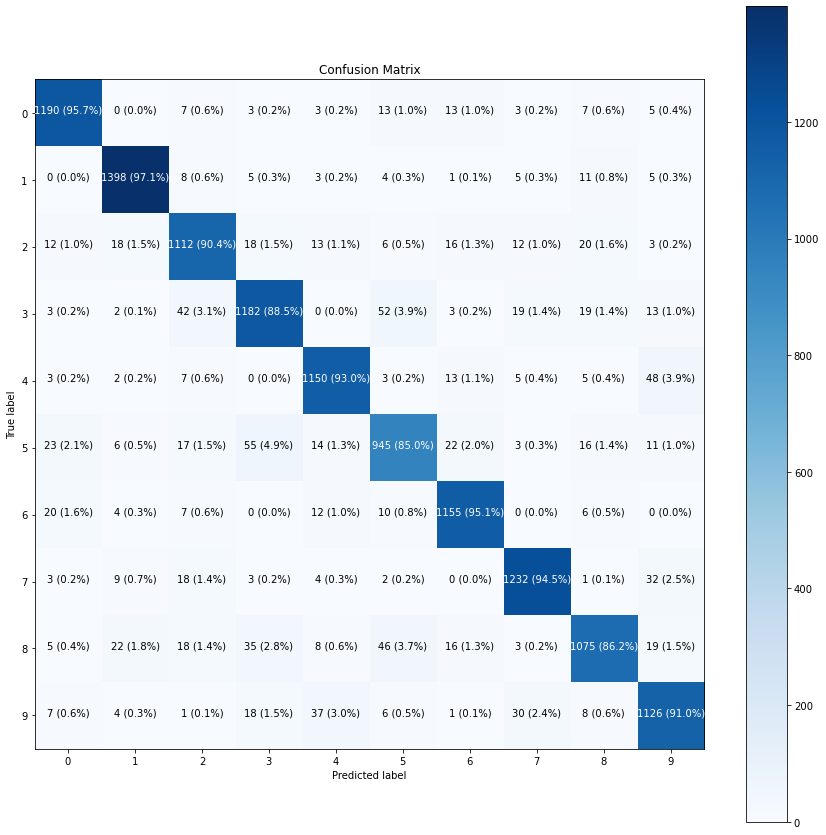

In [118]:
class_name = [0,1,2,3,4,5,6,7,8,9]

make_confusion_matrix(y_true=y_test, 
                      y_pred=y_preds_nn,
                      classes=class_name,
                      figsize=(15, 15),
                      text_size=10)

## Model Summary

In [215]:
model.summary()

Model: "tuning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_1 (Dense)            (None, 8)                 6280      
                                                                 
 hidden_2 (Dense)            (None, 8)                 72        
                                                                 
 output_layer (Dense)        (None, 10)                90        
                                                                 
Total params: 6,442
Trainable params: 6,442
Non-trainable params: 0
_________________________________________________________________


# Prediction Data Test

## Data Test Sample

In [126]:
df_test_norm.sample(5)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
21072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Change to Tensor

In [127]:
test_data = tf.constant(df_test_norm)
test_data[:5]

<tf.Tensor: shape=(5, 784), dtype=float64, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])>

## Predict

In [130]:
#Probability
predict_proba = model.predict(test_data)
predict_proba[:5]

array([[1.6056250e-04, 1.3451462e-13, 9.9968779e-01, 1.5082833e-04,
        2.9089248e-12, 2.6896888e-07, 7.7481872e-08, 9.3422265e-09,
        3.9795438e-07, 2.2646738e-08],
       [9.9958962e-01, 1.7057848e-14, 1.8231640e-05, 9.3102742e-08,
        8.7994296e-17, 3.9211239e-04, 2.9256540e-08, 9.3272515e-11,
        3.4500193e-08, 1.5115487e-12],
       [4.8941853e-05, 1.9199538e-04, 5.9208972e-04, 1.3096857e-02,
        1.2918143e-01, 4.8230635e-03, 3.5611217e-04, 2.7434058e-02,
        3.0111525e-02, 7.9416382e-01],
       [4.9630697e-03, 1.9857066e-06, 1.7010209e-01, 7.0884274e-03,
        2.1251532e-01, 5.6633726e-03, 1.0883669e-02, 2.5193685e-01,
        1.0041386e-02, 3.2680392e-01],
       [2.5625635e-05, 3.3167226e-03, 5.5398750e-01, 4.3863052e-01,
        9.0036698e-09, 2.0094409e-03, 1.3102794e-05, 4.2722795e-06,
        2.0065007e-03, 6.3855055e-06]], dtype=float32)

In [132]:
#prediction
data_pred = predict_proba.argmax(axis=1)
data_pred[0]

2

## Visualization

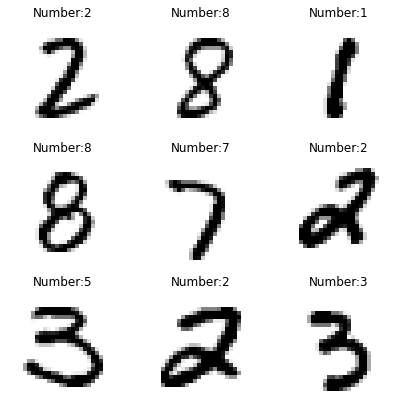

In [160]:
plt.figure(figsize=(7,7))
for i in range(9):
    ax = plt.subplot(3,3,i+1).axis(False)
    index = random.choice(range(len(df_test_norm)))
    plt.imshow(df_test_norm.iloc[index].to_numpy(dtype='float32').reshape((28, 28, 1)) / 255.0,cmap = plt.cm.binary)
    plt.title(f'Number:{data_pred[index]}')

## Prediction New Data

### Image Converter Function

In [193]:
# load and prepare the image
def load_image(filename):
    # load the image
    img = load_img(filename, grayscale=True, target_size=(28, 28))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 1 channel
    img = img.reshape(28, 28)
    # prepare pixel data
    img = img.astype('float32')
    img = img / 255.0
    return img

### Image Visualization

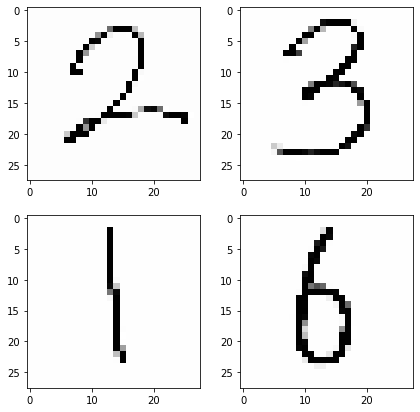

In [213]:
plt.figure(figsize=(7,7))
A = 0
testing = ['test1.jpeg','test2.jpeg','test3.jpeg','test4.jpg']

for i in testing:
    A+=1
    plt.subplot(2,2,A)
    plt.imshow(load_image(i),cmap = plt.cm.binary)

### Prediction

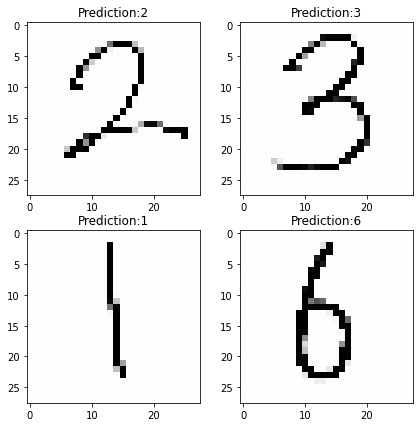

In [214]:
plt.figure(figsize=(7,7))
A = 0
testing = ['test1.jpeg','test2.jpeg','test3.jpeg','test4.jpg']

for i in testing:
    A+=1
    plt.subplot(2,2,A)
    plt.imshow(load_image(i),cmap = plt.cm.binary)
    plt.title(f'Prediction:{np.argmax((tf.round(model.predict(load_image(i).reshape(1,1,784)))))}')

# Conclusion

## Summary Model

In [230]:
pd.DataFrame({'Model':["Basic Neural Network","Neural Network Model","Neural Netwrok Hypertuned"],
            'Accuracy Data Train':[sc_model1[1],sc_model6[1],sc_model[1]],
            'Accuracy Data Test':[sc_model1_t[1],sc_model6_t[1],sc_model_t[1]],
             }).set_index('Model')

,Accuracy Data Train,Accuracy Data Test
Model,,
Basic Neural Network,0.930544,0.917857
Neural Network Model,0.849524,0.832143
Neural Netwrok Hypertuned,0.933605,0.917857


This model can differentiate single number based on input picture, but there are some limitation such as:
* Model hard to differentiate the different style of number.
* The position number on pictre is important.
* Model only prefectly predict particular number (1,2,3,6).
* Model can only predict number with white color and black background color.

Overall Artificial Neural Network can be used to **Computer Vision**, but its not recommended.

## Recommendation

Use **Convolutional Neural** Network for Computer Vision